# Importance Sampling and the Cross-Entropy Method

I recently stumbled across the Cross-Entropy Method (CEM), which is an important sampling method for optimizing black-box functions without gradient information. This method can be used in a number of reinforcement learning scenarios and it seemed useful to learn more about it. I highly recommend [this article](https://web.mit.edu/6.454/www/www_fall_2003/gew/CEtutorial.pdf), which gives a nicely written introduction to the CEM. This blog post largely follows this article and supplements it with practical examples written in Python using scipy and numpy.

In [588]:
import math
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
import numpy.random as random
random.seed(0)

import networkx as nx

## Rare event simulation and importance sampling

Assume we have a random Graph with random edges of probabiliy $p=0.1$ and 


The graph has edge weights $x = (x_1, x_2, \dots x_{n_\text{edges}})$, where each edge $x_j$ is exponentially distributed with mean $u_j$. The probability density function is therefore

$$
f(x; u) = \exp\left\{- \sum_{i=1}^{n_\text{edges}} \frac{x_j }{u_j}\right\} \prod_{i=1}^{n_\text{edges}} \frac{1}{u_j}
$$

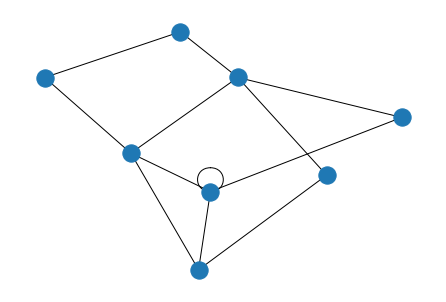

In [589]:
# compute random variables for each edge:
def gen_edge_weights(nedges, scale_params):
  edge_weights = np.array([random.exponential(scale=ui) for ui in scale_params])
  return edge_weights

def reset_edge_weights(adjacency_matrix, data_rvs=gen_edge_weights, scale_params=None):
  if scale_params == None:
    scale_params = [1.0 for _ in range(0, adjacency_matrix.nnz)]
  adjacency_matrix.data = data_rvs(adjacency_matrix.nnz, scale_params)
  return adjacency_matrix

# generate the graph
def generate_graph(nnodes=8, density=0.2, data_rvs=gen_edge_weights, scale_params=None):
  adjacency_matrix = sparse.random(nnodes, nnodes, density=density)
  adjacency_matrix = reset_edge_weights(adjacency_matrix, data_rvs=gen_edge_weights, scale_params=scale_params)
  adjacency_matrix = sparse.csr_matrix(adjacency_matrix)
  return adjacency_matrix

adjacency_matrix = generate_graph()  
graph = nx.from_scipy_sparse_matrix(adjacency_matrix)
nx.draw(graph)

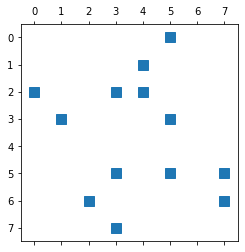

In [590]:
plt.spy(adjacency_matrix)
plt.show()

We want to estimate the probability of the shortest path exceeding a certain value. One way to do this is a crude Monte-Carlo simulation. We can look at the distribution by sampling different graphs and evaluating the shortest path between the first and last node. This quickly becomes intractable.

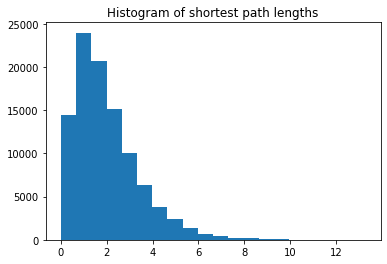

In [591]:
# get the shortest path from the first index to the last index
def compute_shortest_path(adjacency_matrix):
  dist_matrix = sparse.csgraph.shortest_path(adjacency_matrix, indices=0) # computes distance from index 0 to 1
  return dist_matrix[-1]

niter = 100000

dists = []
for i in range(0, niter):
  reset_edge_weights(adjacency_matrix)
  d = compute_shortest_path(adjacency_matrix)
  dists.append(d)

plt.hist(dists, bins=20)
plt.title("Histogram of shortest path lengths")
plt.show()

We observe that the data seems to follow a beta distribution. We can also use this to estimate the probability of the shortest path exceeding a certain length, i.e.

$$
P(S(X) \geq \gamma) = \mathbb{E}[I_{\{S(X) \geq \gamma\}}]
$$

We can estimate this probability with Monte-Carlo sampling using the unbiased estimator

$$
l = \frac{1}{N} \sum_{i=1}^N I_{\{S(X) \geq \gamma\}}.
$$

In [592]:
dists = np.array(dists)
gamma = 5.0
prob = sum(dists >= gamma) / len(dists);
print("P( S >=", gamma ,") =", prob)

P( S >= 5.0 ) = 0.04073


As only a small fractions of paths satisfy this condition, it will take a large number of potentially costly evaluations to determine this quantity to a high precision. This is especially the case for a large $\gamma$.

An alternative approach is to sample the distribution in an adaptive way which samples the extreme cases more often, while accounting for the bias in the sampling. This approach is called *importance sampling* (IS). We replace the original probability density function $f(X)$ with $g(X)$, and evaluate

$$
P(S(X) \geq \gamma) = \int I_{\{S(x) \geq \gamma\}} \frac{f(x)}{g(x)} g(x) \, \mathrm{d}x = \mathbb{E}_g\left[I_{\{S(X) \geq \gamma\}} \frac{f(X)}{g(X)} \right],
$$

which corresponds to the expected value taken with respect to $g(X)$. Effectively, $g$ represents a change of measure, which helps us determine the rare event probability more effectively. As such, it is also called the importance sampling density.

We can again use Monte-Carlo simulation again to estimate $P(S(X) \geq \gamma)$, this time using unbiased importance-sampling estimator

$$
\hat{l} = \frac{1}{N} \sum_{i=1}^N I_{\{S(X) \geq \gamma\}} W(X_i),
$$

where we have introduced the likelihood ratio $W(x) = f(x)/g(x)$. In our case we can choose $X_i$ to be exponentially distributed with mean $v_i$. This yiedlds the likelihood ratio

$$
W(x; u, v) = \frac{f(x; u)}{f(x; v)} = \exp\left\{- \sum_{j=1}^{n_\text{edges}} x_j \left( \frac{1}{u_j} - \frac{1}{v_j}\right)\right\} \prod_{j=1}^{n_\text{edges}} \frac{v_j}{u_j}
$$

Let us begin by implementing the likelihood ratio $W$:

In [593]:
niter = 1000; # from now on we use less iterations and treat the previously computed value as ground truth

In [594]:
# Let us first set two
u = [1.0 for _ in range(0, adjacency_matrix.nnz)]
v = [2.3 for _ in range(0, adjacency_matrix.nnz)] # this value is completely arbitrary for the moment.

def likelihood_ratio(x, u, v):
  assert(len(x) == len(u) == len(v))
  nedges = len(x)
  ratio = 1.0
  for j in range(0, nedges):
    ratio = ratio * math.exp( -1.0 * x[j] * (1 / u[j] - 1 / v[j]) ) * v[j] / u[j]
  return ratio

likelihood_ratio(adjacency_matrix.data, u, v)

100.1337310709432

Let us use this to estimate the probability from before:

In [595]:
lhat = 0.0
lhats = []
for i in range(0, niter):
  adjacency_matrix = reset_edge_weights(adjacency_matrix, scale_params=v)
  d = compute_shortest_path(adjacency_matrix)
  indicator = float(d >= gamma)
  w = likelihood_ratio(adjacency_matrix.data, u, v)
  lhat = lhat * i / (i+1) + w * indicator / (i+1) # update the running mean
  lhats.append(lhat)

print("P( S >=", gamma ,") =", lhat)

P( S >= 5.0 ) = 0.017307292939427833


There seems to be some discrepancy in the two estimators. Let us compare how both estimators, $l$ and $\hat{l}$ converge to the real probability:

In [596]:
l = 0.0
ls = []
for i in range(0, niter):
  adjacency_matrix = reset_edge_weights(adjacency_matrix, scale_params=u)
  d = compute_shortest_path(adjacency_matrix)
  indicator = float(d >= gamma)
  l = l * i / (i+1) + indicator / (i+1) # update the running mean
  ls.append(l)

print("P( S >=", gamma ,") =", l)

P( S >= 5.0 ) = 0.03300000000000005


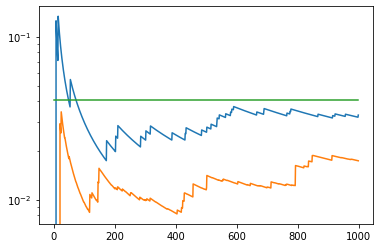

In [597]:
plt.semilogy(ls)
plt.semilogy(lhats)
plt.semilogy(prob*np.ones(niter))
plt.show()

We observe that the addition of the likelihood ratio allows the estimator to perform larger jumps, which corresponds to situations where 

A strength of the CE method is that it allows for an estimation of the optimal parameter $v$. The following algorithm determines $v$ iteratively, before it computes the estimated value. The computation essentially proceeds in the following 3 steps:
- Sample multiple samples $X_1, \dots, X_N$ from $f(\cdot,v_t)$ and select an elite fraction with the highest score (shortest path length)
- Re-compute a new $v_{t+1}$ based on the elite fraction. Repeat the previous step unless each sample in the elite fraction has a score larger than $\gamma$
- Use the final $v_t$ and the samples drawn from the corresponding distribution to compute $\hat{l}$

In [598]:
nsamples = 100
maxestim = 1000
elite_fraction = 0.2
nelites = math.ceil(elite_fraction * nsamples)

v = u
for iter in range(0, maxestim):
  variables = []
  scores = []
  samples = []
  for isample in range(0, nsamples):
    adjacency_matrix = reset_edge_weights(adjacency_matrix, scale_params=v)
    d = compute_shortest_path(adjacency_matrix)
    variables.append(adjacency_matrix.data)
    scores.append(d)
    samples.append(adjacency_matrix.data)
  elite_indices = np.argsort(scores)[-nelites:]
  scores = np.array(scores)
  gammat = scores[elite_indices[0]]
  if gammat >= gamma:
    gammat = gamma

  # compute the updated update v
  denom = 0
  vnew = np.zeros_like(v)
  for isample in elite_indices:
    adjacency_matrix.data = samples[isample]
    w = likelihood_ratio(adjacency_matrix.data, u, v)
    vnew = vnew + w * adjacency_matrix.data
    denom = denom + w
  print("denom = ", denom)
  vnew = vnew / denom
  v = list(vnew)
  print(v)

  # if we meet this condition we have found a good estimator for v
  if gammat == gamma:
    break
  
    

denom =  20.0
[2.0789798919206306, 0.9024464762768563, 0.8627621246562098, 0.8741796854029736, 0.7761899312655961, 1.2234794861721052, 1.1254125136733524, 0.8705156455685585, 1.4404731874688532, 2.1824415800815418, 0.9487045412184418, 1.1400298100385728, 0.7927247604165989]
denom =  1.2683237586489633
[3.224206201194761, 0.5463708679613192, 0.7308473034563716, 0.6248508665955568, 0.9961466192923538, 0.9608405754824076, 1.0585343061690926, 1.2988417102231453, 1.1739976090256605, 3.9220051019696607, 1.004512885408134, 0.9093843972270678, 0.715268208419546]


We can repeat the computation of $\hat{l}$, this time using the estimator that we have computed for v:

In [599]:
lhat = 0
lhats = []
for i in range(0, niter):
  adjacency_matrix = reset_edge_weights(adjacency_matrix, scale_params=v)
  d = compute_shortest_path(adjacency_matrix)
  indicator = float(d >= gamma)
  w = likelihood_ratio(adjacency_matrix.data, u, v)
  lhat = lhat * i / (i+1) + w * indicator / (i+1) # update the running mean
  lhats.append(lhat)

print("P( S >=", gamma ,") =", lhat)

P( S >= 5.0 ) = 0.03927248212577538


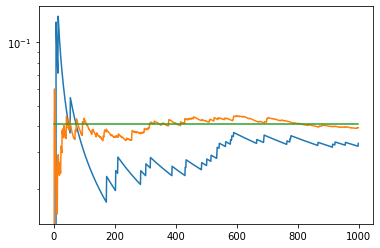

In [600]:
plt.semilogy(ls)
plt.semilogy(lhats)
plt.semilogy(prob*np.ones(niter))
plt.show()

In [601]:
lhats[-1]

0.03927248212577538

In [602]:
ls[-1]

0.03300000000000005

## Application to reinforcement learning

A difficult setting for optimizers is policy search in reinforcement learning.

## References

- [https://web.mit.edu/6.454/www/www_fall_2003/gew/CEtutorial.pdf](https://web.mit.edu/6.454/www/www_fall_2003/gew/CEtutorial.pdf)